# Linear Regression model - broken by Experience Level
## Step by step plan:

Data ingestion<br>

Data wrangling and feature engineering
- Outlier removal<br>
- Tokenization and cleanup of job titles<br>
- Creation of dummies for all categorical variables<br>

*Train test split, including breakdown by Experience Level*<br>

Post split wrangling<br>
- Feature selection and database cleanup<br>
- Independent variable normalization<br>

Note: independent variable was normalized using the same lambda found in the complete model to guarantee results consistency<br>

### Model creation and evaluation
- Parameter evaluation<br>
- Actual vs predicted target variable analysis<br>
- Residuals analysis<br>

### Created models:
- Layered OLS model using exclusively significant independent variables and Experience Level as a layer breakdown<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import ceil, floor
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox, kstest, normaltest, pearsonr
from scipy.special import inv_boxcox

In [2]:
sns.set() # makes all charts look better by default

## Data Ingestion

In [3]:
#aijobs = pd.read_csv(r'https://ai-jobs.net/salaries/download/salaries.csv')
aijobs = pd.read_csv(r'C:\Users\Captain\Documents\CURSOS\MBA ESALQ\salaries.csv')
# Last accessed at 2024-03-23

In [4]:
aijobs # first look at the data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,Data Engineer,120000,CHF,136363,CH,50,CH,L
1,2024,SE,PT,Data Architect,212000,USD,212000,US,0,US,M
2,2024,SE,PT,Data Architect,93300,USD,93300,US,0,US,M
3,2024,MI,FT,Data Product Owner,321830,USD,321830,US,0,US,M
4,2024,MI,FT,Data Product Owner,124690,USD,124690,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
14796,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
14797,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
14798,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
14799,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [5]:
aijobs.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,14801.000000,14801,14801,14801,1.480100e+04,14801,14801.000000,14801,14801.000000,14801,14801
unique,NaN,4,4,152,NaN,23,NaN,88,NaN,77,3
top,NaN,SE,FT,Data Engineer,NaN,USD,NaN,US,NaN,US,M
freq,NaN,9673,14735,3158,NaN,13648,NaN,12896,NaN,12945,13638
mean,2023.136748,NaN,NaN,NaN,1.650843e+05,NaN,149895.249307,NaN,32.801838,NaN,NaN
std,0.700349,NaN,NaN,NaN,3.566669e+05,NaN,69037.515089,NaN,46.502476,NaN,NaN
min,2020.000000,NaN,NaN,NaN,1.400000e+04,NaN,15000.000000,NaN,0.000000,NaN,NaN
25%,2023.000000,NaN,NaN,NaN,1.021000e+05,NaN,102000.000000,NaN,0.000000,NaN,NaN
50%,2023.000000,NaN,NaN,NaN,1.422000e+05,NaN,141525.000000,NaN,0.000000,NaN,NaN
75%,2024.000000,NaN,NaN,NaN,1.875000e+05,NaN,185900.000000,NaN,100.000000,NaN,NaN


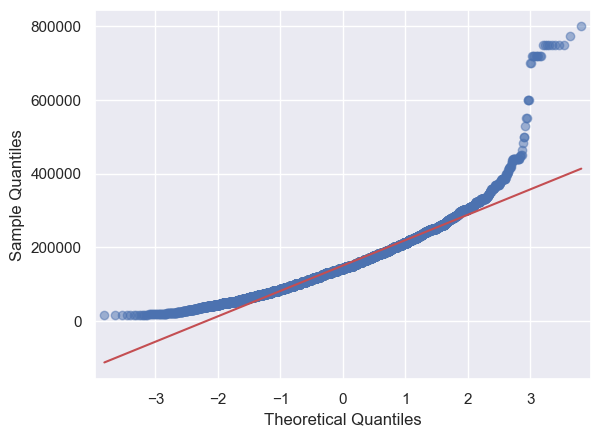

In [6]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

# Common data wrangling
These steps would be equally done for train and test bases with no population or sampled information, only individual ones, so no data leakage will occur if done now.

### Outlier removal

In [7]:
# The first outliers are extremely out of touch with the remainder of the database.
# They will skew the results too much and must be removed.
# According to Hair, from 2.5 to 4 standards deviations might be used to remove outliers.
# Visually, 4 deviations cover the worst cases.

mean = aijobs['salary_in_usd'].mean()
std = aijobs['salary_in_usd'].std()
outmax = mean + 2.5 * std
print(outmax)
outliers = aijobs[aijobs['salary_in_usd'] > outmax].index
print(outliers)
print(len(outliers))

aijobs.drop(outliers, inplace=True)
aijobs.reset_index(drop=True, inplace=True)
aijobs.sort_values('salary_in_usd', ascending=False).head()

322489.0370309836
Index([  153,   157,   213,   230,   237,   320,   370,   410,   428,   455,
       ...
       13453, 13632, 14474, 14526, 14531, 14583, 14728, 14747, 14793, 14796],
      dtype='int64', length=241)
241


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
3475,2024,SE,FT,Machine Learning Engineer,322000,USD,322000,US,100,US,M
3682,2024,SE,FT,Machine Learning Engineer,322000,USD,322000,US,100,US,M
513,2024,SE,FT,Data Scientist,322000,USD,322000,US,0,US,M
3,2024,MI,FT,Data Product Owner,321830,USD,321830,US,0,US,M
1879,2024,SE,FT,Research Scientist,321000,USD,321000,US,100,US,M


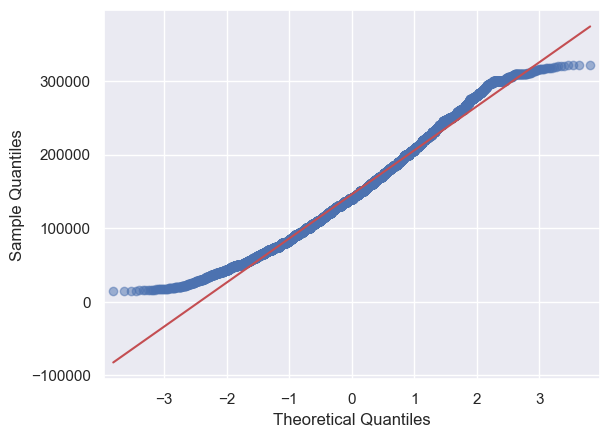

In [8]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

In [9]:
aijobs.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,14560.000000,14560,14560,14560,1.456000e+04,14560,14560.000000,14560,14560.000000,14560,14560
unique,NaN,4,4,150,NaN,22,NaN,87,NaN,77,3
top,NaN,SE,FT,Data Engineer,NaN,USD,NaN,US,NaN,US,M
freq,NaN,9497,14496,3143,NaN,13416,NaN,12668,NaN,12716,13411
mean,2023.133036,NaN,NaN,NaN,1.611725e+05,NaN,145771.642239,NaN,33.063187,NaN,NaN
std,0.699676,NaN,NaN,NaN,3.578791e+05,NaN,59893.563509,NaN,46.598261,NaN,NaN
min,2020.000000,NaN,NaN,NaN,1.400000e+04,NaN,15000.000000,NaN,0.000000,NaN,NaN
25%,2023.000000,NaN,NaN,NaN,1.000000e+05,NaN,100000.000000,NaN,0.000000,NaN,NaN
50%,2023.000000,NaN,NaN,NaN,1.402500e+05,NaN,140000.000000,NaN,0.000000,NaN,NaN
75%,2024.000000,NaN,NaN,NaN,1.850000e+05,NaN,185000.000000,NaN,100.000000,NaN,NaN


## Feature Engineering

In [10]:
# There is no value in local currency salaries as they're not scaled.
# Salary in USD conveys the same useful information in a scaled manner.
aijobs.drop('salary', axis=1, inplace=True)

In [11]:
# An interesting variable to research
aijobs['work_abroad'] = aijobs['employee_residence'] != aijobs['company_location']
aijobs['work_abroad'] = aijobs['work_abroad'].astype(int)
aijobs.tail(10)

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,work_abroad
14550,2020,MI,FT,Data Engineer,USD,130800,ES,100,US,M,1
14551,2020,SE,FT,Machine Learning Engineer,EUR,45618,HR,100,HR,S,0
14552,2021,SE,FT,Director of Data Science,USD,168000,JP,0,JP,S,0
14553,2021,MI,FT,Data Scientist,SGD,119059,SG,100,IL,M,1
14554,2021,MI,FT,Data Engineer,EUR,28369,MT,50,MT,L,0
14555,2021,SE,FT,Data Specialist,USD,165000,US,100,US,L,0
14556,2021,MI,FT,Principal Data Scientist,USD,151000,US,100,US,L,0
14557,2020,EN,FT,Data Scientist,USD,105000,US,100,US,S,0
14558,2020,EN,CT,Business Data Analyst,USD,100000,US,100,US,L,0
14559,2021,SE,FT,Data Science Manager,INR,94665,IN,50,IN,L,0


In [12]:
# remote_ratio is categorical; the correct way to interpret those numbers is:
#   0 == On Site (less than 20% remote)
#  50 == Partially remote/hybird
# 100 == Fully remote (more than 80% remote)
# therefore using it as numerical would be creating a spurious relationship.
# It has to be dummified and will be switched for easier interpretation.

aijobs.loc[aijobs['remote_ratio'] == 0, 'remote_ratio'] = 'On_Site'
aijobs.loc[aijobs['remote_ratio'] == 50, 'remote_ratio'] = 'Hybrid'
aijobs.loc[aijobs['remote_ratio'] == 100, 'remote_ratio'] = 'Remote'

aijobs['remote_ratio']

0         Hybrid
1        On_Site
2        On_Site
3        On_Site
4        On_Site
          ...   
14555     Remote
14556     Remote
14557     Remote
14558     Remote
14559     Hybrid
Name: remote_ratio, Length: 14560, dtype: object

In [13]:
# Categorical columns will receive appropriate treatment
categorical_columns = ['employment_type', 'salary_currency', 'employee_residence', 'remote_ratio', 
                       'company_location', 'company_size']

In [14]:
# Quick look at job titles. This will receive a quick NLP method for processing.
print(len(aijobs['job_title'].unique()), "different job titles \n")
print(aijobs['job_title'].unique())

150 different job titles 

['Data Engineer' 'Data Architect' 'Data Product Owner' 'MLOps Engineer'
 'Data Specialist' 'Data Manager' 'Analytics Engineer' 'Data Analyst'
 'Machine Learning Scientist' 'Business Intelligence Engineer'
 'Data Scientist' 'Business Intelligence Analyst' 'Data Science'
 'Data Analytics Manager' 'Encounter Data Management Professional'
 'Machine Learning Engineer' 'Research Scientist' 'Research Engineer'
 'AI Engineer' 'Data Modeler' 'Research Analyst' 'ML Engineer'
 'Data Science Consultant' 'Applied Scientist' 'BI Analyst'
 'Data Integration Engineer' 'Data Integration Specialist'
 'Machine Learning Operations Engineer'
 'Machine Learning Infrastructure Engineer' 'Data Developer'
 'Business Intelligence' 'CRM Data Analyst' 'ETL Developer'
 'Business Intelligence Manager' 'Data Science Engineer' 'AI Architect'
 'Robotics Engineer' 'BI Developer' 'Head of Data' 'Data Science Manager'
 'Cloud Database Engineer' 'Data Operations Analyst'
 'Data Science Analyst' 

In [15]:
# Work on the terms contained in job titles.
terms = []
for title in aijobs['job_title'].unique():
    for word in title.split():
        terms.append(word)
terms = sorted(set(terms))
print(len(terms), "different terms in these titles \n")
print(terms)

80 different terms in these titles 

['&', 'AI', 'AWS', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Autonomous', 'Azure', 'BI', 'Big', 'Biologist', 'Business', 'CRM', 'Cloud', 'Compliance', 'Computational', 'Computer', 'Consultant', 'Data', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Encounter', 'Engineer', 'Finance', 'Financial', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Intelligence', 'Lead', 'Learning', 'ML', 'MLOps', 'Machine', 'Management', 'Manager', 'Managing', 'Marketing', 'Modeler', 'Modeller', 'NLP', 'Operations', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Professional', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Research', 'Researcher', 'Robotics', 'Sales', 'Science', 'Scientist', 'Software', 'Specialist', 'Staff', 'Strategist', 'Strategy', 'Technician', 'Vehicle', 'Vision', 'Visualization', 'of']


In [16]:
stop_words = ['&', 'of', 'Data', 'Learning', 'Computational', 'Computer', 'Autonomous', 'Technician', 'Professional']
# Justification: '&', 'of' and 'Data' are too generic for this project.
# 'Learning' has two contexts: Machine Learning and Deep Learning, yet both "Machine" and "Deep" are unique to them,
# so there's nothing to be gained from adding it.
# "Autonomous Vehicle Technician" is a job title whose words are all unique, so a single one is enough.
# "Computational Biologist" shares the same issue.
# "Encounter Data Management Professional" is the only to use "Encounter" and "Professional".
# "Computer Vision" is present in more than one job, but all of them use this same sequence, so it's the same situation.

In [17]:
synonym_terms = ['ML','Machine','MLOps', 'Operations','Business','BI','Intelligence','AWS','Cloud','Azure','Modeller',
                 'Modeler','Engineering','Engineer','Financial','Finance','Researcher','Research','Science','Scientist',
                 'Strategy','Strategist','Management','Manager', 'Managing']

In [18]:
# this uses the same pressupositions as above, but some words will mean the same thing.
synonyms = {'Machine': 'Machine|ML|MLOps',      # ML is short for Machine Learning
            'Operations':'MLOps|Operations',    # Ops is short for Operations
            'Intelligence':'Intelligence|BI',   # BI is short for Business Intelligence (Intelligence is exclusive to BI)
            'Business':'Business|BI',           # For consistency (Business is not exclusive to BI)
            'Cloud':'Cloud|AWS|Azure',          # There is a single instance for AWS and for Azure; both specific cloud tools
            'Modeler':'Modeler|Modeller',
            'Engineer':'Engineer|Engineering',
            'Finance':'Finance|Financial',
            'Research':'Research|Researcher',
            'Scientist':'Scientist|Science',
            'Strategist':'Strategist|Strategy',
            'Manager':'Management|Manager|Managing'}
# Note: Analyst and Analytics in this context will mean different things.

In [19]:
clean_terms = terms.copy()                                                   # copy method to keep the original list
[clean_terms.remove(term) for term in stop_words if term in clean_terms]     # remove stop words
[clean_terms.remove(term) for term in synonym_terms if term in clean_terms]  # synonyms will be processed differently
print(len(clean_terms), "terms after cleaning\n", len(synonyms), "synonyms\n ", len(clean_terms)+len(synonyms), "total terms\n")
print(clean_terms)

47 terms after cleaning
 12 synonyms
  59 total terms

['AI', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Big', 'Biologist', 'CRM', 'Compliance', 'Consultant', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Encounter', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Lead', 'Marketing', 'NLP', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Robotics', 'Sales', 'Software', 'Specialist', 'Staff', 'Vehicle', 'Vision', 'Visualization']


In [20]:
# dummization for all chosen job keywords
for job_string in clean_terms:
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(job_string, case=False).astype(int)
for job_string in synonyms.keys():
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(f'{synonyms[job_string]}', case=False).astype(int)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,job_name_Intelligence,job_name_Business,job_name_Cloud,job_name_Modeler,job_name_Engineer,job_name_Finance,job_name_Research,job_name_Scientist,job_name_Strategist,job_name_Manager
0,2024,MI,FT,Data Engineer,CHF,136363,CH,Hybrid,CH,L,...,0,0,0,0,1,0,0,0,0,0
1,2024,SE,PT,Data Architect,USD,212000,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
2,2024,SE,PT,Data Architect,USD,93300,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
3,2024,MI,FT,Data Product Owner,USD,321830,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
4,2024,MI,FT,Data Product Owner,USD,124690,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# dummization for all other categorical columns
df_dummies = pd.get_dummies(aijobs[categorical_columns], dtype=int)
aijobs = pd.concat([aijobs, df_dummies], axis=1)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_location_ZA,company_size_L,company_size_M,company_size_S
0,2024,MI,FT,Data Engineer,CHF,136363,CH,Hybrid,CH,L,...,0,0,0,0,0,0,0,1,0,0
1,2024,SE,PT,Data Architect,USD,212000,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
2,2024,SE,PT,Data Architect,USD,93300,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
3,2024,MI,FT,Data Product Owner,USD,321830,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
4,2024,MI,FT,Data Product Owner,USD,124690,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0


In [22]:
aijobs[categorical_columns].describe().loc['unique']

employment_type        4
salary_currency       22
employee_residence    87
remote_ratio           3
company_location      77
company_size           3
Name: unique, dtype: object

In [23]:
# To establish the features, categorical columns that are not dummies will need to be removed. Target variable too.

X_vars = aijobs.columns.tolist()
[X_vars.remove(col) for col in categorical_columns if col in X_vars]
X_vars.remove('job_title')
X_vars.remove('salary_in_usd')
X_vars.remove('experience_level')

In [24]:
# Comprehensive dummies will need one instance removed.
# They could be picked by hand, but the algorithm below selects the most popular for deletion.

c_dummies = aijobs[['employment_type_FL', 'employment_type_PT', 'employment_type_CT', 'employment_type_FT']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['remote_ratio_Remote', 'remote_ratio_Hybrid', 'remote_ratio_On_Site']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['company_size_S', 'company_size_M', 'company_size_L']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

# These larger dummies will be implied in the intercept.
X_vars.remove('salary_currency_USD')
X_vars.remove('employee_residence_US')
X_vars.remove('company_location_US')

print(X_vars)

['work_year', 'work_abroad', 'job_name_AI', 'job_name_Admin', 'job_name_Analyst', 'job_name_Analytics', 'job_name_Applied', 'job_name_Architect', 'job_name_Associate', 'job_name_Big', 'job_name_Biologist', 'job_name_CRM', 'job_name_Compliance', 'job_name_Consultant', 'job_name_Database', 'job_name_Decision', 'job_name_Deep', 'job_name_DevOps', 'job_name_Developer', 'job_name_Director', 'job_name_ETL', 'job_name_Encounter', 'job_name_Head', 'job_name_Infrastructure', 'job_name_Insight', 'job_name_Integration', 'job_name_Lead', 'job_name_Marketing', 'job_name_NLP', 'job_name_Ops', 'job_name_Owner', 'job_name_Pipeline', 'job_name_Power', 'job_name_Practitioner', 'job_name_Principal', 'job_name_Product', 'job_name_Programmer', 'job_name_Prompt', 'job_name_Quality', 'job_name_Quantitative', 'job_name_Reporting', 'job_name_Robotics', 'job_name_Sales', 'job_name_Software', 'job_name_Specialist', 'job_name_Staff', 'job_name_Vehicle', 'job_name_Vision', 'job_name_Visualization', 'job_name_Machi

# Splitting and working the data before model fit

In [25]:
aijobs['experience_level'].unique()

array(['MI', 'SE', 'EN', 'EX'], dtype=object)

In [26]:
X_train = {}
X_test = {}
y_train = {}
y_test = {}
lmbda = 0.472512427421 #selected from the previously created model

for exp in aijobs['experience_level'].unique():
    X_train[exp], X_test[exp], y_train[exp], y_test[exp] = train_test_split(aijobs[aijobs['experience_level'] == exp][X_vars], 
                                                                            aijobs[aijobs['experience_level'] == exp]['salary_in_usd'], 
                                                                            test_size=0.25, random_state=42)
    y_vals = boxcox(y_train[exp], lmbda)
    y_train[exp] = pd.Series(y_vals, index=y_train[exp].index, name='transformed_salary')
    y_vals = boxcox(y_test[exp], lmbda)
    y_test[exp] = pd.Series(y_vals, index=y_test[exp].index, name='transformed_salary')

In [27]:
X_train['MI']

,work_year,work_abroad,job_name_AI,job_name_Admin,job_name_Analyst,job_name_Analytics,job_name_Applied,job_name_Architect,job_name_Associate,job_name_Big,...,company_location_SE,company_location_SG,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_VN,company_location_ZA,company_size_L,company_size_S
5274,2023,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1283,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
403,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14257,2022,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9868,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505,2024,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3647,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4132,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2849,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# To delete columns with too few instances in order to avoid overfitting
# Hair says 5 entries is a minimum threshold; any dummy with less than 5 examples is too prone to overfitting.

def del_vars(X_train, X_test, y_train, y_test, printing=False):
    """
    This function deletes all columns in training base that have too few instances and will result in overfitting
    It also deletes every row that had an instance in such columns in order to prevent assumptions implied in the intecept
    As these variables are rendered unworkable, they are also deleted from test base (no information leak happens)
    Every row removed from independent variables bases (X) is also removed from the dependent variable array (y).
    """
    
    if printing == True:
        print("Before:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    deletions = 1 #just to enter the loop
    train_dropped = []
    while deletions > 0:
        deletions = X_train.shape[0] # store the dataframe size for later comparison
        X_sum = X_train.sum()
        exclusion_list = X_sum[X_sum < 5].index # create the exclusion column list

        # deleting all rows with any positive value in those variables
        X_delete = X_train[exclusion_list].sum(axis=1)
        rows_to_delete = X_delete[X_delete != 0]
        X_train.drop(rows_to_delete.index, inplace=True)
        
        [train_dropped.append(item) for item in rows_to_delete.index] # list all deleted rows for later consistency wity y array
        deletions = deletions - X_train.shape[0] # difference from previous dataframe size
        if printing == True:
            print('Rows deleted:', deletions) # deleted rows in this loop
            print('Columns dropped:', len(exclusion_list)) # cumulative columns to be deleted
        # loop until there are no more deleted rows
        
    X_train.drop(exclusion_list, axis=1, inplace=True) # dropping columns from train base now
    
    test_deletion = X_test[exclusion_list].sum(axis=1) # filter a dataframe by select all exclusion rows and their sum
    test_dropped = test_deletion[test_deletion > 0].index # finding all rows with a positive value on any of those dummies
    X_test.drop(test_dropped, inplace=True) # dropping unworkable test rows
    X_test.drop(exclusion_list, axis=1, inplace=True) # dropping columns from test base
    
    # shaping dependent variable arrays to match independent variables dataframes
    y_train.drop(train_dropped, inplace=True)
    y_test.drop(test_dropped, inplace=True)
    if printing == True:
        print("After:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [29]:
for exp in aijobs['experience_level'].unique():
    print(exp)
    del_vars(X_train[exp], X_test[exp], y_train[exp], y_test[exp], printing=True)
    print('\n')

MI
Before: (2627, 251) (2627,) (876, 251) (876,)
Rows deleted: 130
Columns dropped: 176
Rows deleted: 13
Columns dropped: 185
Rows deleted: 0
Columns dropped: 185
After: (2484, 66) (2484,) (825, 66) (825,)


SE
Before: (7122, 251) (7122,) (2375, 251) (2375,)
Rows deleted: 81
Columns dropped: 166
Rows deleted: 3
Columns dropped: 168
Rows deleted: 0
Columns dropped: 168
After: (7038, 83) (7038,) (2333, 83) (2333,)


EN
Before: (858, 251) (858,) (286, 251) (286,)
Rows deleted: 99
Columns dropped: 204
Rows deleted: 17
Columns dropped: 211
Rows deleted: 0
Columns dropped: 211
After: (742, 40) (742,) (243, 40) (243,)


EX
Before: (312, 251) (312,) (104, 251) (104,)
Rows deleted: 23
Columns dropped: 228
Rows deleted: 3
Columns dropped: 231
Rows deleted: 0
Columns dropped: 231
After: (286, 20) (286,) (87, 20) (87,)




In [30]:
for exp in aijobs['experience_level'].unique():
    X_train[exp] = sm.add_constant(X_train[exp])
    X_test[exp] = sm.add_constant(X_test[exp])

# Starting the Model

In [31]:
# Create a model

def model_creation(X_train, X_test, y_train, y_test, cov_type):
    # A few variables look like they still have high p-values even in an isolated model.
    # Loop until only significant variables are present
    NOT_significant_vars = [1] # creation of a non empty list to enter the loop
    while NOT_significant_vars != []:
        # The model is created, but a new one using only the previously resulting significant variables 
        # did not render a new model that had all variables resulting significant.
        # A stepwise deletion for these variables will be done here until that happens.
        OLS_model = sm.OLS(y_train, X_train).fit(cov_type=cov_type)

        # Bring all not significant variables into a single list
        NOT_significant_vars = OLS_model.pvalues[OLS_model.pvalues > 0.05]
        NOT_significant_vars = list(NOT_significant_vars.index)

        # remove the intercept from this list so it isn't removed from the model
        if 'const' in NOT_significant_vars:
            NOT_significant_vars.remove('const')

        X_train.drop(NOT_significant_vars, axis=1, inplace=True)
        X_test.drop(NOT_significant_vars, axis=1, inplace=True)
        del_vars(X_train, X_test, y_train, y_test, printing=True)
    
    return OLS_model

In [32]:
# Design a function to display standardized information
def create_scatter(y_pred, y_test, X_test):

    residuals = y_test - y_pred
    comparison_df = pd.DataFrame((y_test, y_pred, residuals)).transpose()
    comparison_df.columns = ["Observed", "Predicted", "Residual"]
    display(comparison_df.describe())

    m, b = np.polyfit(y_test, y_pred, deg=1)
    R_2 = pearsonr(y_test, y_pred)
    
    # Adjusting charts' limits (with a buffer)
    llim = min(y_test.min(), y_pred.min()) - 30
    ulim = max(y_test.max(), y_pred.max()) + 30
    llim = floor(llim/100)*100
    ulim = ceil(ulim/100)*100

    print('Scatter plot of Predicted vs Actual values')

    g = sns.jointplot(x=y_test, y=y_pred, kind="reg", height=6.7, xlim=(llim, ulim), ylim=(llim, ulim), 
                      joint_kws={'scatter_kws':dict(s=15, alpha=0.2)}, line_kws=dict(color="r"))

    for i in [400, 700]:
        g.refline(x=i, y=i, linestyle=":", alpha=.5)

    plt.xlabel('Observed y values')
    plt.ylabel('Predicted y values')

    plt.show()

    print(f'Prediction R squared: {R_2[0]**2:.4f} p-value: {R_2[1]:.4f}')
    print(f'y = {m:.4f}x {b:+.1f} \n\n')
    
    
    print('RESIDUALS PLOT')

    plt.figure(figsize=(6.7, 3.5))
    plt.scatter(y_pred, residuals, s=15, alpha=.2)
    plt.xlabel('Predicted y values')
    plt.ylabel('Residuals')
    plt.show()    
        
    het = sms.het_breuschpagan(residuals, X_test.fillna(0))
    print('Breusch-Pegan Test for Heteroskedasticity:\n',
          'If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.\n',
          f'Lagrange multiplier statistic: {het[0]:.4f}, p-value: {het[1]:.4f}\n',
         sep='') 
    if het[1] < 0.05:
        print('Homoskedasticity is rejected.')
    print('\n\n')
    
    # tests and histogram to look at residuals' normality
    print('RESIDUALS NORMALITY')
    print(normaltest(residuals))
    print(kstest(residuals, "norm"))
    print('Residuals Histogram')
    plt.hist(residuals, bins=20)
    plt.xlabel('Residuals')
    plt.ylabel('Amount of instances')
    plt.show()

nonrobust 

MI 

Before: (2484, 23) (2484,) (825, 23) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 23) (2484,) (825, 23) (825,)
Before: (2484, 22) (2484,) (825, 22) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 22) (2484,) (825, 22) (825,)
Before: (2484, 22) (2484,) (825, 22) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 22) (2484,) (825, 22) (825,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     53.12
Date:                Fri, 12 Apr 2024   Prob (F-statistic):          1.80e-160
Time:                        00:07:42   Log-Likelihood:                -14699.
No. Observations:                2484   AIC:                         2.944e+04
Df Residuals:                    2465   BIC:                         2.955e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   489.3674      3.806    128.581      0.000     481.904     496.831
job_name_Applied         75.1215     11.855      6.336      0.000      51.874      98.369
job_name_Architect       81.9849     22.856      3.587      0.000      37.166     126.803
job_name_Consultant     -53.9772     25.235     -2.139      0.033    -103.460      -4.494
job_name_Product         87.0451     24.728      3.520      0.000      38.556     135.534
job_name_Machine         56.6427      6.762      8.376      0.000      43.382      69.903
job_name_Operations     -44.7820     20.462     -2.189      0.029     -84.907      -4.657
job_name_Modeler         66.3199     28.815      2.302      0.021       9.816     122.823
job_name_Engineer        54.3411      4.746     11.451      0.000      45.035      63.647
job_name_Research        37.8020      7.837      4.823      0.000      22.433      53.171
job_name_Scientist       63.1035      4.923     12.819      0.000      53.450      72.756
job_name_Manager         31.9557      8.430      3.791      0.000      15.426      48.486
salary_currency_CAD    -103.6110     32.159     -3.222      0.001    -166.673     -40.549
salary_currency_GBP    -117.6980      6.492    -18.130      0.000    -130.428    -104.968
employee_residence_BR   -59.4326     17.157     -3.464      0.001     -93.077     -25.788
employee_residence_GR   -84.0545     17.134     -4.906      0.000    -117.652     -50.457
employee_residence_LV   -85.0530     20.243     -4.202      0.000    -124.748     -45.358
remote_ratio_Remote     -17.9168      4.137     -4.330      0.000     -26.030      -9.804
company_location_BR     -59.4326     17.157     -3.464      0.001     -93.077     -25.788
company_location_GR     -84.0545     17.134     -4.906      0.000    -117.652     -50.457
company_location_IN    -288.1165     28.647    -10.058      0.000    -344.291    -231.942
company_location_LV     -85.0530     20.243     -4.202      0.000    -124.748     -45.358
==============================================================================
Omnibus:                        7.361   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.389
Skew:                           0.134   Prob(JB):                       0.0249
Kurtosis:                       2.991   Cond. No.                     4.57e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.64e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""


___________________________________________________________

nonrobust 

SE 

Before: (7038, 32) (7038,) (2333, 32) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 32) (7038,) (2333, 32) (2333,)
Before: (7038, 30) (7038,) (2333, 30) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 30) (7038,) (2333, 30) (2333,)
Before: (7038, 28) (7038,) (2333, 28) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 28) (7038,) (2333, 28) (2333,)
Before: (7038, 28) (7038,) (2333, 28) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 28) (7038,) (2333, 28) (2333,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     119.1
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:07:42   Log-Likelihood:                -41321.
No. Observations:                7038   AIC:                         8.269e+04
Df Residuals:                    7013   BIC:                         8.286e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.305e+04   3465.346     -3.765      0.000   -1.98e+04   -6255.038
work_year                 6.7120      1.713      3.919      0.000       3.354      10.070
work_abroad             -62.1376     26.783     -2.320      0.020    -114.641      -9.634
job_name_AI              31.6689     10.363      3.056      0.002      11.355      51.983
job_name_Applied         37.6726      6.107      6.169      0.000      25.701      49.644
job_name_Architect       80.6766      5.879     13.722      0.000      69.151      92.202
job_name_Consultant     -93.1768     13.110     -7.107      0.000    -118.876     -67.477
job_name_Lead            27.6871     13.649      2.029      0.043       0.931      54.443
job_name_Principal      107.2393     30.987      3.461      0.001      46.495     167.984
job_name_Quality        -52.7532     21.591     -2.443      0.015     -95.078     -10.428
job_name_Vision          81.3969     19.962      4.078      0.000      42.266     120.528
job_name_Machine         56.4129      3.155     17.879      0.000      50.228      62.598
job_name_Engineer        65.1956      3.030     21.520      0.000      59.257      71.134
job_name_Research        36.4911      4.688      7.784      0.000      27.302      45.680
job_name_Scientist       84.4421      3.074     27.469      0.000      78.416      90.468
job_name_Manager         44.5720      6.900      6.460      0.000      31.047      58.097
salary_currency_CAD     -83.7497     21.554     -3.886      0.000    -126.002     -41.498
salary_currency_EUR    -166.8717     12.018    -13.885      0.000    -190.430    -143.313
salary_currency_GBP    -141.7740      8.043    -17.626      0.000    -157.542    -126.006
salary_currency_INR    -280.1693     27.770    -10.089      0.000    -334.606    -225.732
employee_residence_CO   -91.7744     17.567     -5.224      0.000    -126.211     -57.338
employee_residence_UA   -40.7557     19.341     -2.107      0.035     -78.669      -2.842
employee_residence_ZA   -47.9115     17.900     -2.677      0.007     -83.001     -12.822
company_location_BR    -277.0963     38.673     -7.165      0.000    -352.907    -201.286
company_location_CO     -91.7744     17.567     -5.224      0.000    -126.211     -57.338
company_location_ES     -89.3007     16.035     -5.569      0.000    -120.734     -57.867
company_location_UA     -40.7557     19.341     -2.107      0.035     -78.669      -2.842
company_location_ZA     -47.9115     17.900     -2.677      0.007     -83.001     -12.822
==============================================================================
Omnibus:                       12.946   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.629
Skew:                           0.055   Prob(JB):       


___________________________________________________________

nonrobust 

EN 

Before: (742, 13) (742,) (243, 13) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 13) (742,) (243, 13) (243,)
Before: (742, 8) (742,) (243, 8) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 8) (742,) (243, 8) (243,)
Before: (742, 8) (742,) (243, 8) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 8) (742,) (243, 8) (243,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     43.11
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           4.75e-51
Time:                        00:07:42   Log-Likelihood:                -4403.1
No. Observations:                 742   AIC:                             8822.
Df Residuals:                     734   BIC:                             8859.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 477.5680      4.640    102.923      0.000     468.459     486.677
job_name_Applied      115.0697     28.084      4.097      0.000      59.935     170.205
job_name_Machine       43.0267     14.503      2.967      0.003      14.554      71.500
job_name_Research      71.0175     10.442      6.801      0.000      50.519      91.517
employment_type_PT    -96.1761     29.665     -3.242      0.001    -154.414     -37.938
salary_currency_EUR  -144.6379     15.772     -9.170      0.000    -175.602    -113.674
salary_currency_GBP  -132.1813     12.889    -10.255      0.000    -157.485    -106.878
remote_ratio_Remote   -34.8274      7.584     -4.592      0.000     -49.716     -19.939
==============================================================================
Omnibus:                       14.306   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.035
Skew:                           0.188   Prob(JB):                     4.46e-05
Kurtosis:                       3.712   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


___________________________________________________________

nonrobust 

EX 

Before: (286, 6) (286,) (87, 6) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 6) (286,) (87, 6) (87,)
Before: (286, 3) (286,) (87, 3) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 3) (286,) (87, 3) (87,)
Before: (286, 3) (286,) (87, 3) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 3) (286,) (87, 3) (87,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     7.074
Date:                Fri, 12 Apr 2024   Prob (F-statistic):            0.00100
Time:                        00:07:42   Log-Likelihood:                -1725.4
No. Observations:                 286   AIC:                             3457.
Df Residuals:                     283   BIC:                             3468.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 627.9735      7.725     81.286      0.000     612.767     643.180
job_name_Director      52.3171     22.069      2.371      0.018       8.876      95.758
remote_ratio_Remote    35.1047     12.426      2.825      0.005      10.645      59.564
==============================================================================
Omnibus:                        8.952   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.590
Skew:                          -0.319   Prob(JB):                       0.0225
Kurtosis:                       2.520   Cond. No.                         4.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


___________________________________________________________



,Observed,Predicted,Residual
count,3488.000000,3488.000000,3488.000000
mean,576.170665,572.178512,3.992153
std,113.954862,71.293286,88.797692
min,205.549688,183.334053,-301.402986
25%,497.660696,530.295551,-57.079909
50%,579.179592,595.491174,2.791268
75%,653.421001,614.737634,63.796338
max,841.599606,759.143420,278.255801


Scatter plot of Predicted vs Actual values


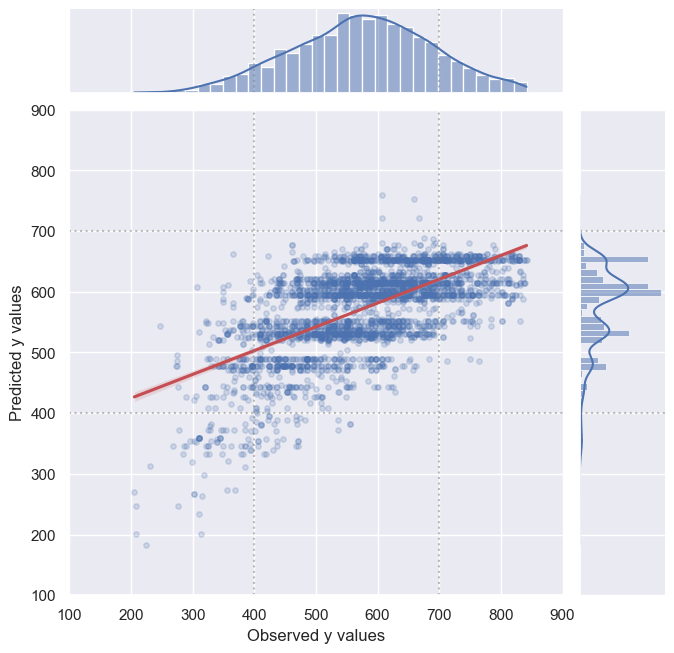

Prediction R squared: 0.3928 p-value: 0.0000
y = 0.3921x +346.3 


RESIDUALS PLOT


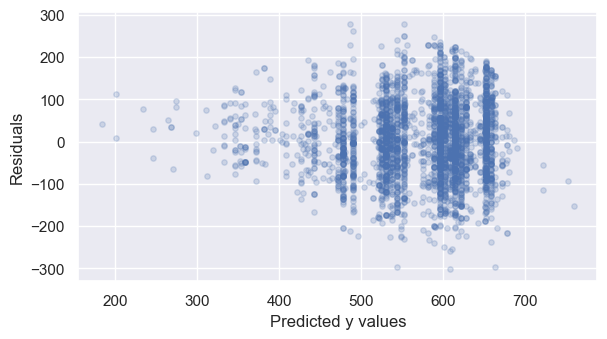

Breusch-Pegan Test for Heteroskedasticity:
If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
Lagrange multiplier statistic: 103.4458, p-value: 0.0000

Homoskedasticity is rejected.



RESIDUALS NORMALITY
NormaltestResult(statistic=5.754864082851296, pvalue=0.05627909982606276)
KstestResult(statistic=0.49774541265668776, pvalue=0.0, statistic_location=2.7063489272586594, statistic_sign=-1)
Residuals Histogram


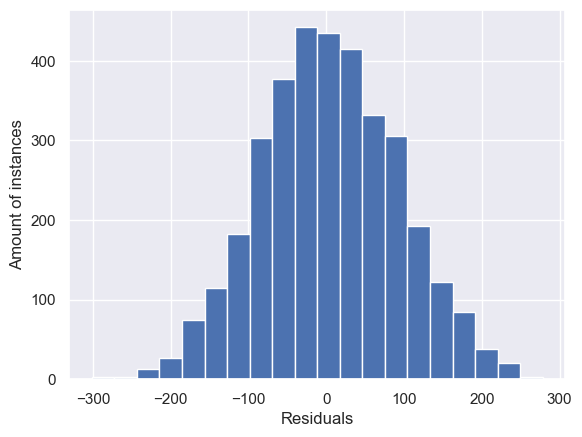

_____________________________________________________________________________

NEXT HC
_____________________________________________________________________________





HC0 

MI 

Before: (2484, 22) (2484,) (825, 22) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 22) (2484,) (825, 22) (825,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 18
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     88.34
Date:                Fri, 12 Apr 2024   Prob (F-statistic):          2.74e-250
Time:                        00:07:45   Log-Likelihood:                -14699.
No. Observations:                2484   AIC:                         2.944e+04
Df Residuals:                    2465   BIC:                         2.955e+04
Df Model:                          18                                         
Covariance Type:                  HC0                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   489.3674      3.427    142.785      0.000     482.650     496.085
job_name_Applied         75.1215     11.474      6.547      0.000      52.632      97.611
job_name_Architect       81.9849     17.515      4.681      0.000      47.656     116.314
job_name_Consultant     -53.9772     16.554     -3.261      0.001     -86.423     -21.532
job_name_Product         87.0451     24.388      3.569      0.000      39.246     134.844
job_name_Machine         56.6427      7.277      7.784      0.000      42.380      70.905
job_name_Operations     -44.7820     18.684     -2.397      0.017     -81.401      -8.163
job_name_Modeler         66.3199     27.414      2.419      0.016      12.590     120.050
job_name_Engineer        54.3411      4.500     12.076      0.000      45.521      63.161
job_name_Research        37.8020      9.879      3.826      0.000      18.439      57.165
job_name_Scientist       63.1035      4.866     12.967      0.000      53.566      72.641
job_name_Manager         31.9557      7.981      4.004      0.000      16.314      47.597
salary_currency_CAD    -103.6110     33.416     -3.101      0.002    -169.104     -38.118
salary_currency_GBP    -117.6980      5.212    -22.581      0.000    -127.914    -107.482
employee_residence_BR   -59.4326     10.244     -5.802      0.000     -79.510     -39.356
employee_residence_GR   -84.0545     12.724     -6.606      0.000    -108.994     -59.115
employee_residence_LV   -85.0530     12.805     -6.642      0.000    -110.151     -59.955
remote_ratio_Remote     -17.9168      4.046     -4.428      0.000     -25.847      -9.987
company_location_BR     -59.4326     10.244     -5.802      0.000     -79.510     -39.356
company_location_GR     -84.0545     12.724     -6.606      0.000    -108.994     -59.115
company_location_IN    -288.1165     13.061    -22.059      0.000    -313.715    -262.518
company_location_LV     -85.0530     12.805     -6.642      0.000    -110.151     -59.955
==============================================================================
Omnibus:                        7.361   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.389
Skew:                           0.134   Prob(JB):                       0.0249
Kurtosis:                       2.991   Cond. No.                     4.57e+17
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The smallest eigenvalue is 1.64e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""


___________________________________________________________

HC0 

SE 

Before: (7038, 25) (7038,) (2333, 25) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 25) (7038,) (2333, 25) (2333,)
Before: (7038, 25) (7038,) (2333, 25) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 25) (7038,) (2333, 25) (2333,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 22
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     198.8
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:07:45   Log-Likelihood:                -41325.
No. Observations:                7038   AIC:                         8.270e+04
Df Residuals:                    7015   BIC:                         8.285e+04
Df Model:                          22                                         
Covariance Type:                  HC0                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.347e+04   3423.874     -3.936      0.000   -2.02e+04   -6764.027
work_year                 6.9229      1.692      4.091      0.000       3.606      10.240
job_name_AI              29.4293     12.034      2.445      0.014       5.842      53.016
job_name_Applied         37.5571      5.840      6.431      0.000      26.110      49.004
job_name_Architect       80.7868      6.109     13.225      0.000      68.814      92.760
job_name_Consultant     -93.0996      7.586    -12.273      0.000    -107.967     -78.232
job_name_Lead            28.5969     14.076      2.032      0.042       1.008      56.186
job_name_Principal      109.7493     20.901      5.251      0.000      68.784     150.715
job_name_Quality        -52.8091     25.824     -2.045      0.041    -103.423      -2.195
job_name_Vision          78.3254     15.013      5.217      0.000      48.900     107.751
job_name_Machine         56.0663      3.209     17.472      0.000      49.777      62.356
job_name_Engineer        65.2189      3.026     21.555      0.000      59.289      71.149
job_name_Research        36.3781      5.091      7.146      0.000      26.401      46.355
job_name_Scientist       84.3150      2.988     28.214      0.000      78.458      90.172
job_name_Manager         43.6861      6.877      6.353      0.000      30.208      57.164
salary_currency_CAD     -83.5269     15.715     -5.315      0.000    -114.328     -52.726
salary_currency_EUR    -172.3307     11.492    -14.996      0.000    -194.855    -149.807
salary_currency_GBP    -141.8333      6.808    -20.833      0.000    -155.177    -128.490
salary_currency_INR    -286.2312     22.245    -12.867      0.000    -329.830    -242.633
employee_residence_CO   -91.6799     11.164     -8.212      0.000    -113.561     -69.799
employee_residence_ZA   -47.9566     11.886     -4.035      0.000     -71.253     -24.660
company_location_BR    -276.3714     35.391     -7.809      0.000    -345.736    -207.007
company_location_CO     -91.6799     11.164     -8.212      0.000    -113.561     -69.799
company_location_ES     -83.9068     13.594     -6.172      0.000    -110.551     -57.262
company_location_ZA     -47.9566     11.886     -4.035      0.000     -71.253     -24.660
==============================================================================
Omnibus:                        9.838   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.001
Skew:                           0.048   Prob(JB):                       0.0111
Kurtosis:                       2.853   Cond. No.                     7.76e+20
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The smallest eigenval


___________________________________________________________

HC0 

EN 

Before: (742, 8) (742,) (243, 8) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 8) (742,) (243, 8) (243,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     67.34
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           6.52e-75
Time:                        00:07:46   Log-Likelihood:                -4403.1
No. Observations:                 742   AIC:                             8822.
Df Residuals:                     734   BIC:                             8859.
Df Model:                           7                                         
Covariance Type:                  HC0                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 477.5680      4.568    104.541      0.000     468.614     486.522
job_name_Applied      115.0697     36.061      3.191      0.001      44.391     185.748
job_name_Machine       43.0267     19.175      2.244      0.025       5.444      80.610
job_name_Research      71.0175     14.223      4.993      0.000      43.140      98.895
employment_type_PT    -96.1761     17.876     -5.380      0.000    -131.213     -61.139
salary_currency_EUR  -144.6379     10.863    -13.314      0.000    -165.930    -123.346
salary_currency_GBP  -132.1813      8.727    -15.147      0.000    -149.285    -115.077
remote_ratio_Remote   -34.8274      7.362     -4.730      0.000     -49.258     -20.397
==============================================================================
Omnibus:                       14.306   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.035
Skew:                           0.188   Prob(JB):                     4.46e-05
Kurtosis:                       3.712   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""


___________________________________________________________

HC0 

EX 

Before: (286, 3) (286,) (87, 3) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 3) (286,) (87, 3) (87,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     10.30
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           4.80e-05
Time:                        00:07:46   Log-Likelihood:                -1725.4
No. Observations:                 286   AIC:                             3457.
Df Residuals:                     283   BIC:                             3468.
Df Model:                           2                                         
Covariance Type:                  HC0                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 627.9735      7.580     82.847      0.000     613.117     642.830
job_name_Director      52.3171     14.614      3.580      0.000      23.674      80.960
remote_ratio_Remote    35.1047     12.641      2.777      0.005      10.328      59.882
==============================================================================
Omnibus:                        8.952   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.590
Skew:                          -0.319   Prob(JB):                       0.0225
Kurtosis:                       2.520   Cond. No.                         4.01
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""


___________________________________________________________



,Observed,Predicted,Residual
count,3488.000000,3488.000000,3488.000000
mean,576.170665,572.204424,3.966241
std,113.954862,71.321195,88.853603
min,205.549688,183.334053,-301.069878
25%,497.660696,530.300372,-57.603979
50%,579.179592,595.519239,2.859237
75%,653.421001,618.010095,63.934759
max,841.599606,761.334902,278.255801


Scatter plot of Predicted vs Actual values


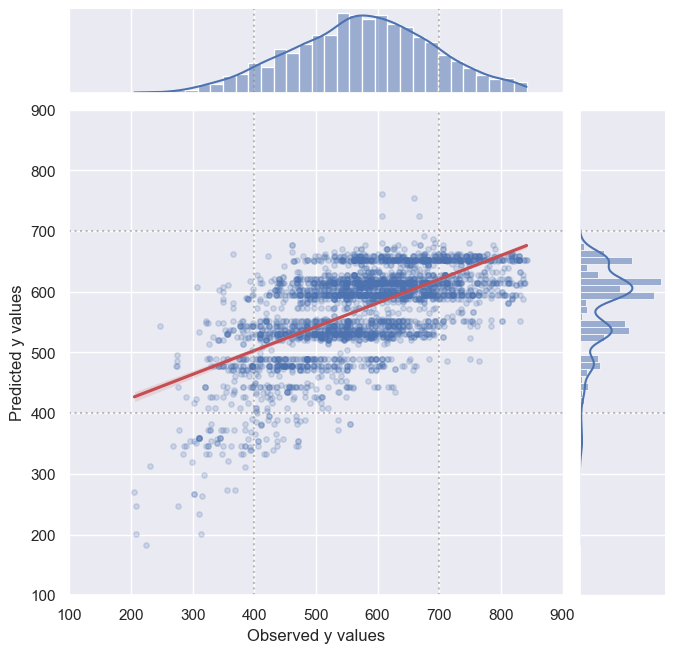

Prediction R squared: 0.3920 p-value: 0.0000
y = 0.3919x +346.4 


RESIDUALS PLOT


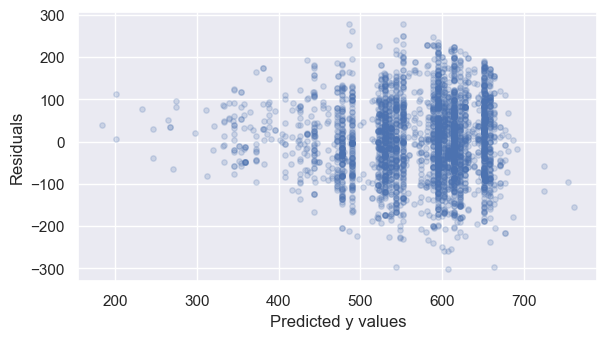

Breusch-Pegan Test for Heteroskedasticity:
If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
Lagrange multiplier statistic: 100.4908, p-value: 0.0000

Homoskedasticity is rejected.



RESIDUALS NORMALITY
NormaltestResult(statistic=4.817733484767538, pvalue=0.08991713613433927)
KstestResult(statistic=0.49836846162412995, pvalue=0.0, statistic_location=3.001142994767406, statistic_sign=-1)
Residuals Histogram


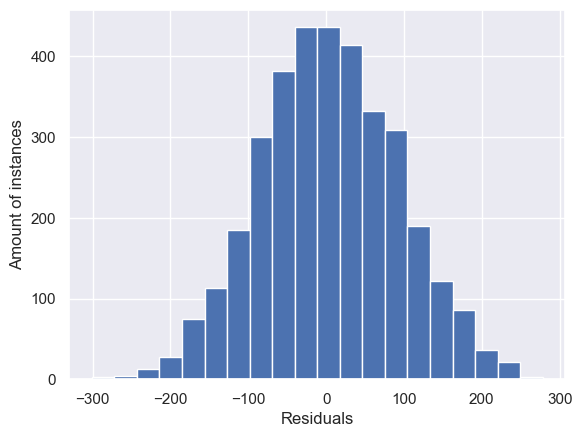

_____________________________________________________________________________

NEXT HC
_____________________________________________________________________________





HC1 

MI 

Before: (2484, 22) (2484,) (825, 22) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 22) (2484,) (825, 22) (825,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 18
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     87.66
Date:                Fri, 12 Apr 2024   Prob (F-statistic):          1.07e-248
Time:                        00:07:49   Log-Likelihood:                -14699.
No. Observations:                2484   AIC:                         2.944e+04
Df Residuals:                    2465   BIC:                         2.955e+04
Df Model:                          18                                         
Covariance Type:                  HC1                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   489.3674      3.440    142.238      0.000     482.624     496.111
job_name_Applied         75.1215     11.519      6.522      0.000      52.546      97.697
job_name_Architect       81.9849     17.582      4.663      0.000      47.524     116.446
job_name_Consultant     -53.9772     16.618     -3.248      0.001     -86.547     -21.407
job_name_Product         87.0451     24.482      3.556      0.000      39.062     135.028
job_name_Machine         56.6427      7.305      7.754      0.000      42.325      70.960
job_name_Operations     -44.7820     18.755     -2.388      0.017     -81.542      -8.022
job_name_Modeler         66.3199     27.519      2.410      0.016      12.383     120.257
job_name_Engineer        54.3411      4.517     12.029      0.000      45.487      63.195
job_name_Research        37.8020      9.917      3.812      0.000      18.365      57.239
job_name_Scientist       63.1035      4.885     12.918      0.000      53.529      72.678
job_name_Manager         31.9557      8.011      3.989      0.000      16.254      47.658
salary_currency_CAD    -103.6110     33.544     -3.089      0.002    -169.356     -37.866
salary_currency_GBP    -117.6980      5.232    -22.495      0.000    -127.953    -107.443
employee_residence_BR   -59.4326     10.283     -5.780      0.000     -79.587     -39.278
employee_residence_GR   -84.0545     12.773     -6.581      0.000    -109.089     -59.019
employee_residence_LV   -85.0530     12.855     -6.617      0.000    -110.248     -59.858
remote_ratio_Remote     -17.9168      4.061     -4.411      0.000     -25.877      -9.957
company_location_BR     -59.4326     10.283     -5.780      0.000     -79.587     -39.278
company_location_GR     -84.0545     12.773     -6.581      0.000    -109.089     -59.019
company_location_IN    -288.1165     13.111    -21.975      0.000    -313.814    -262.419
company_location_LV     -85.0530     12.855     -6.617      0.000    -110.248     -59.858
==============================================================================
Omnibus:                        7.361   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.389
Skew:                           0.134   Prob(JB):                       0.0249
Kurtosis:                       2.991   Cond. No.                     4.57e+17
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 1.64e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""


___________________________________________________________

HC1 

SE 

Before: (7038, 25) (7038,) (2333, 25) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 25) (7038,) (2333, 25) (2333,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 22
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     198.2
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:07:49   Log-Likelihood:                -41325.
No. Observations:                7038   AIC:                         8.270e+04
Df Residuals:                    7015   BIC:                         8.285e+04
Df Model:                          22                                         
Covariance Type:                  HC1                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.347e+04   3429.482     -3.929      0.000   -2.02e+04   -6753.035
work_year                 6.9229      1.695      4.084      0.000       3.600      10.245
job_name_AI              29.4293     12.054      2.441      0.015       5.804      53.055
job_name_Applied         37.5571      5.850      6.420      0.000      26.091      49.023
job_name_Architect       80.7868      6.119     13.203      0.000      68.794      92.779
job_name_Consultant     -93.0996      7.598    -12.253      0.000    -107.991     -78.208
job_name_Lead            28.5969     14.099      2.028      0.043       0.963      56.231
job_name_Principal      109.7493     20.935      5.242      0.000      68.717     150.782
job_name_Quality        -52.8091     25.866     -2.042      0.041    -103.506      -2.112
job_name_Vision          78.3254     15.038      5.208      0.000      48.851     107.799
job_name_Machine         56.0663      3.214     17.444      0.000      49.767      62.366
job_name_Engineer        65.2189      3.031     21.520      0.000      59.279      71.159
job_name_Research        36.3781      5.099      7.134      0.000      26.384      46.372
job_name_Scientist       84.3150      2.993     28.168      0.000      78.448      90.182
job_name_Manager         43.6861      6.888      6.343      0.000      30.186      57.186
salary_currency_CAD     -83.5269     15.741     -5.306      0.000    -114.378     -52.675
salary_currency_EUR    -172.3307     11.511    -14.971      0.000    -194.892    -149.770
salary_currency_GBP    -141.8333      6.819    -20.799      0.000    -155.199    -128.468
salary_currency_INR    -286.2312     22.281    -12.846      0.000    -329.901    -242.561
employee_residence_CO   -91.6799     11.182     -8.199      0.000    -113.596     -69.763
employee_residence_ZA   -47.9566     11.905     -4.028      0.000     -71.291     -24.622
company_location_BR    -276.3714     35.449     -7.796      0.000    -345.849    -206.893
company_location_CO     -91.6799     11.182     -8.199      0.000    -113.596     -69.763
company_location_ES     -83.9068     13.617     -6.162      0.000    -110.595     -57.219
company_location_ZA     -47.9566     11.905     -4.028      0.000     -71.291     -24.622
==============================================================================
Omnibus:                        9.838   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.001
Skew:                           0.048   Prob(JB):                       0.0111
Kurtosis:                       2.853   Cond. No.                     7.76e+20
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenval


___________________________________________________________

HC1 

EN 

Before: (742, 8) (742,) (243, 8) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 8) (742,) (243, 8) (243,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     66.62
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           3.03e-74
Time:                        00:07:49   Log-Likelihood:                -4403.1
No. Observations:                 742   AIC:                             8822.
Df Residuals:                     734   BIC:                             8859.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 477.5680      4.593    103.976      0.000     468.566     486.570
job_name_Applied      115.0697     36.257      3.174      0.002      44.007     186.132
job_name_Machine       43.0267     19.279      2.232      0.026       5.240      80.814
job_name_Research      71.0175     14.301      4.966      0.000      42.989      99.046
employment_type_PT    -96.1761     17.973     -5.351      0.000    -131.403     -60.949
salary_currency_EUR  -144.6379     10.922    -13.242      0.000    -166.045    -123.231
salary_currency_GBP  -132.1813      8.774    -15.065      0.000    -149.378    -114.984
remote_ratio_Remote   -34.8274      7.403     -4.705      0.000     -49.336     -20.319
==============================================================================
Omnibus:                       14.306   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.035
Skew:                           0.188   Prob(JB):                     4.46e-05
Kurtosis:                       3.712   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""


___________________________________________________________

HC1 

EX 

Before: (286, 3) (286,) (87, 3) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 3) (286,) (87, 3) (87,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     10.19
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           5.31e-05
Time:                        00:07:49   Log-Likelihood:                -1725.4
No. Observations:                 286   AIC:                             3457.
Df Residuals:                     283   BIC:                             3468.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 627.9735      7.620     82.412      0.000     613.039     642.908
job_name_Director      52.3171     14.691      3.561      0.000      23.522      81.112
remote_ratio_Remote    35.1047     12.708      2.762      0.006      10.197      60.012
==============================================================================
Omnibus:                        8.952   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.590
Skew:                          -0.319   Prob(JB):                       0.0225
Kurtosis:                       2.520   Cond. No.                         4.01
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""


___________________________________________________________



,Observed,Predicted,Residual
count,3488.000000,3488.000000,3488.000000
mean,576.170665,572.204424,3.966241
std,113.954862,71.321195,88.853603
min,205.549688,183.334053,-301.069878
25%,497.660696,530.300372,-57.603979
50%,579.179592,595.519239,2.859237
75%,653.421001,618.010095,63.934759
max,841.599606,761.334902,278.255801


Scatter plot of Predicted vs Actual values


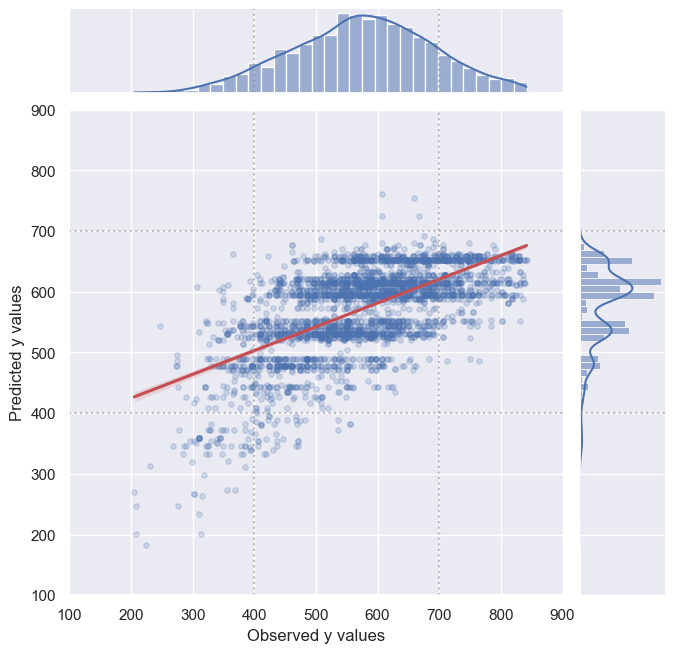

Prediction R squared: 0.3920 p-value: 0.0000
y = 0.3919x +346.4 


RESIDUALS PLOT


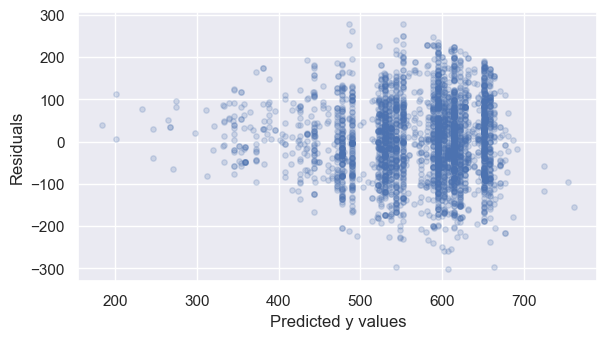

Breusch-Pegan Test for Heteroskedasticity:
If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
Lagrange multiplier statistic: 100.4908, p-value: 0.0000

Homoskedasticity is rejected.



RESIDUALS NORMALITY
NormaltestResult(statistic=4.817733484767538, pvalue=0.08991713613433927)
KstestResult(statistic=0.49836846162412995, pvalue=0.0, statistic_location=3.001142994767406, statistic_sign=-1)
Residuals Histogram


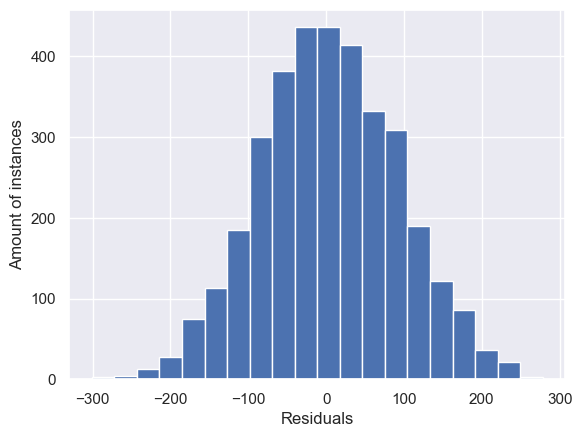

_____________________________________________________________________________

NEXT HC
_____________________________________________________________________________





HC2 

MI 

Before: (2484, 22) (2484,) (825, 22) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 22) (2484,) (825, 22) (825,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 18
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     84.42
Date:                Fri, 12 Apr 2024   Prob (F-statistic):          5.55e-241
Time:                        00:07:52   Log-Likelihood:                -14699.
No. Observations:                2484   AIC:                         2.944e+04
Df Residuals:                    2465   BIC:                         2.955e+04
Df Model:                          18                                         
Covariance Type:                  HC2                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   489.3674      3.437    142.393      0.000     482.631     496.103
job_name_Applied         75.1215     11.608      6.472      0.000      52.370      97.873
job_name_Architect       81.9849     18.078      4.535      0.000      46.553     117.416
job_name_Consultant     -53.9772     17.217     -3.135      0.002     -87.723     -20.232
job_name_Product         87.0451     25.329      3.437      0.001      37.402     136.688
job_name_Machine         56.6427      7.304      7.755      0.000      42.328      70.958
job_name_Operations     -44.7820     19.175     -2.335      0.020     -82.364      -7.200
job_name_Modeler         66.3199     28.890      2.296      0.022       9.697     122.942
job_name_Engineer        54.3411      4.512     12.044      0.000      45.498      63.184
job_name_Research        37.8020      9.927      3.808      0.000      18.345      57.259
job_name_Scientist       63.1035      4.879     12.933      0.000      53.540      72.667
job_name_Manager         31.9557      8.025      3.982      0.000      16.228      47.683
salary_currency_CAD    -103.6110     35.834     -2.891      0.004    -173.844     -33.378
salary_currency_GBP    -117.6980      5.237    -22.474      0.000    -127.962    -107.434
employee_residence_BR   -59.4326     11.045     -5.381      0.000     -81.081     -37.784
employee_residence_GR   -84.0545     13.747     -6.114      0.000    -110.998     -57.111
employee_residence_LV   -85.0530     14.292     -5.951      0.000    -113.064     -57.042
remote_ratio_Remote     -17.9168      4.058     -4.415      0.000     -25.870      -9.963
company_location_BR     -59.4326     11.045     -5.381      0.000     -81.081     -37.784
company_location_GR     -84.0545     13.747     -6.114      0.000    -110.998     -57.111
company_location_IN    -288.1165     13.809    -20.864      0.000    -315.182    -261.051
company_location_LV     -85.0530     14.292     -5.951      0.000    -113.064     -57.042
==============================================================================
Omnibus:                        7.361   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.389
Skew:                           0.134   Prob(JB):                       0.0249
Kurtosis:                       2.991   Cond. No.                     4.57e+17
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenvalue is 1.64e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""


___________________________________________________________

HC2 

SE 

Before: (7038, 25) (7038,) (2333, 25) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 25) (7038,) (2333, 25) (2333,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 22
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     194.0
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:07:52   Log-Likelihood:                -41325.
No. Observations:                7038   AIC:                         8.270e+04
Df Residuals:                    7015   BIC:                         8.285e+04
Df Model:                          22                                         
Covariance Type:                  HC2                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.347e+04   3433.673     -3.924      0.000   -2.02e+04   -6744.821
work_year                 6.9229      1.697      4.079      0.000       3.596      10.249
job_name_AI              29.4293     12.144      2.423      0.015       5.627      53.232
job_name_Applied         37.5571      5.854      6.416      0.000      26.084      49.030
job_name_Architect       80.7868      6.127     13.186      0.000      68.779      92.795
job_name_Consultant     -93.0996      7.669    -12.140      0.000    -108.130     -78.069
job_name_Lead            28.5969     14.288      2.001      0.045       0.592      56.602
job_name_Principal      109.7493     22.898      4.793      0.000      64.870     154.629
job_name_Quality        -52.8091     26.688     -1.979      0.048    -105.117      -0.501
job_name_Vision          78.3254     15.745      4.974      0.000      47.465     109.186
job_name_Machine         56.0663      3.212     17.453      0.000      49.770      62.362
job_name_Engineer        65.2189      3.030     21.521      0.000      59.279      71.159
job_name_Research        36.3781      5.100      7.133      0.000      26.383      46.374
job_name_Scientist       84.3150      2.993     28.172      0.000      78.449      90.181
job_name_Manager         43.6861      6.903      6.328      0.000      30.156      57.216
salary_currency_CAD     -83.5269     16.240     -5.143      0.000    -115.357     -51.697
salary_currency_EUR    -172.3307     11.685    -14.748      0.000    -195.233    -149.428
salary_currency_GBP    -141.8333      6.852    -20.700      0.000    -155.263    -128.404
salary_currency_INR    -286.2312     23.848    -12.002      0.000    -332.972    -239.491
employee_residence_CO   -91.6799     12.232     -7.495      0.000    -115.655     -67.705
employee_residence_ZA   -47.9566     12.974     -3.696      0.000     -73.386     -22.527
company_location_BR    -276.3714     40.081     -6.895      0.000    -354.929    -197.814
company_location_CO     -91.6799     12.232     -7.495      0.000    -115.655     -67.705
company_location_ES     -83.9068     13.830     -6.067      0.000    -111.014     -56.800
company_location_ZA     -47.9566     12.974     -3.696      0.000     -73.386     -22.527
==============================================================================
Omnibus:                        9.838   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.001
Skew:                           0.048   Prob(JB):                       0.0111
Kurtosis:                       2.853   Cond. No.                     7.76e+20
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenval


___________________________________________________________

HC2 

EN 

Before: (742, 8) (742,) (243, 8) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 8) (742,) (243, 8) (243,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     65.28
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           5.18e-73
Time:                        00:07:52   Log-Likelihood:                -4403.1
No. Observations:                 742   AIC:                             8822.
Df Residuals:                     734   BIC:                             8859.
Df Model:                           7                                         
Covariance Type:                  HC2                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 477.5680      4.587    104.118      0.000     468.578     486.558
job_name_Applied      115.0697     38.142      3.017      0.003      40.313     189.826
job_name_Machine       43.0267     19.538      2.202      0.028       4.733      81.321
job_name_Research      71.0175     14.331      4.956      0.000      42.930      99.105
employment_type_PT    -96.1761     19.103     -5.034      0.000    -133.618     -58.734
salary_currency_EUR  -144.6379     11.047    -13.093      0.000    -166.290    -122.986
salary_currency_GBP  -132.1813      8.801    -15.018      0.000    -149.431    -114.931
remote_ratio_Remote   -34.8274      7.413     -4.698      0.000     -49.357     -20.298
==============================================================================
Omnibus:                       14.306   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.035
Skew:                           0.188   Prob(JB):                     4.46e-05
Kurtosis:                       3.712   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""


___________________________________________________________

HC2 

EX 

Before: (286, 3) (286,) (87, 3) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 3) (286,) (87, 3) (87,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     9.976
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           6.50e-05
Time:                        00:07:52   Log-Likelihood:                -1725.4
No. Observations:                 286   AIC:                             3457.
Df Residuals:                     283   BIC:                             3468.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 627.9735      7.604     82.582      0.000     613.069     642.878
job_name_Director      52.3171     14.916      3.507      0.000      23.082      81.552
remote_ratio_Remote    35.1047     12.705      2.763      0.006      10.203      60.007
==============================================================================
Omnibus:                        8.952   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.590
Skew:                          -0.319   Prob(JB):                       0.0225
Kurtosis:                       2.520   Cond. No.                         4.01
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""


___________________________________________________________



,Observed,Predicted,Residual
count,3488.000000,3488.000000,3488.000000
mean,576.170665,572.204424,3.966241
std,113.954862,71.321195,88.853603
min,205.549688,183.334053,-301.069878
25%,497.660696,530.300372,-57.603979
50%,579.179592,595.519239,2.859237
75%,653.421001,618.010095,63.934759
max,841.599606,761.334902,278.255801


Scatter plot of Predicted vs Actual values


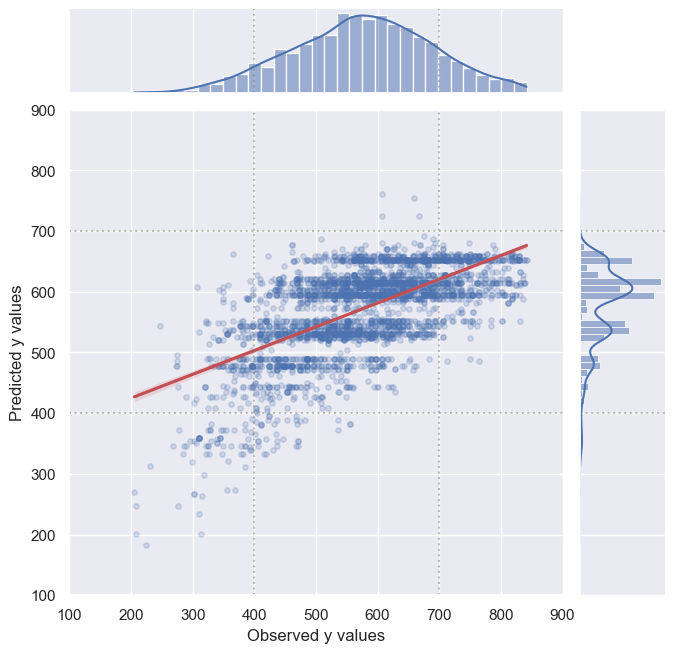

Prediction R squared: 0.3920 p-value: 0.0000
y = 0.3919x +346.4 


RESIDUALS PLOT


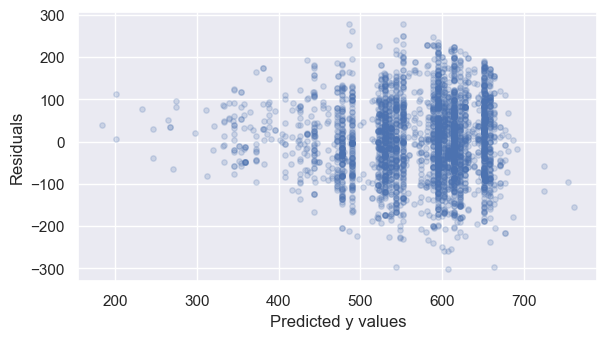

Breusch-Pegan Test for Heteroskedasticity:
If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
Lagrange multiplier statistic: 100.4908, p-value: 0.0000

Homoskedasticity is rejected.



RESIDUALS NORMALITY
NormaltestResult(statistic=4.817733484767538, pvalue=0.08991713613433927)
KstestResult(statistic=0.49836846162412995, pvalue=0.0, statistic_location=3.001142994767406, statistic_sign=-1)
Residuals Histogram


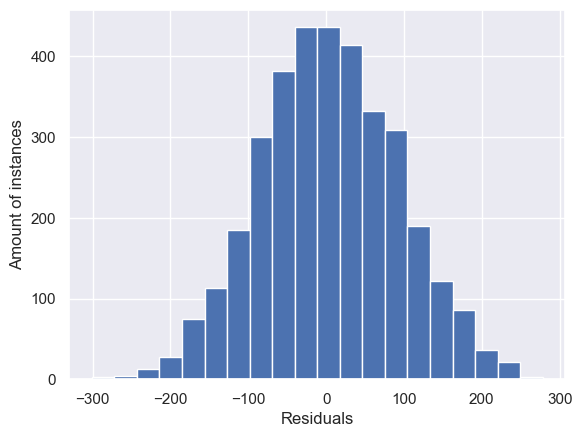

_____________________________________________________________________________

NEXT HC
_____________________________________________________________________________





HC3 

MI 

Before: (2484, 22) (2484,) (825, 22) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 22) (2484,) (825, 22) (825,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 18
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     80.88
Date:                Fri, 12 Apr 2024   Prob (F-statistic):          1.86e-232
Time:                        00:07:55   Log-Likelihood:                -14699.
No. Observations:                2484   AIC:                         2.944e+04
Df Residuals:                    2465   BIC:                         2.955e+04
Df Model:                          18                                         
Covariance Type:                  HC3                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   489.3674      3.447    141.978      0.000     482.612     496.123
job_name_Applied         75.1215     11.749      6.394      0.000      52.095      98.148
job_name_Architect       81.9849     18.659      4.394      0.000      45.413     118.557
job_name_Consultant     -53.9772     17.909     -3.014      0.003     -89.078     -18.876
job_name_Product         87.0451     26.308      3.309      0.001      35.482     138.608
job_name_Machine         56.6427      7.331      7.727      0.000      42.275      71.010
job_name_Operations     -44.7820     19.680     -2.276      0.023     -83.354      -6.210
job_name_Modeler         66.3199     30.447      2.178      0.029       6.645     125.995
job_name_Engineer        54.3411      4.524     12.011      0.000      45.474      63.208
job_name_Research        37.8020      9.976      3.789      0.000      18.249      57.355
job_name_Scientist       63.1035      4.893     12.896      0.000      53.513      72.694
job_name_Manager         31.9557      8.070      3.960      0.000      16.139      47.772
salary_currency_CAD    -103.6110     38.433     -2.696      0.007    -178.938     -28.284
salary_currency_GBP    -117.6980      5.263    -22.365      0.000    -128.013    -107.383
employee_residence_BR   -59.4326     11.913     -4.989      0.000     -82.782     -36.083
employee_residence_GR   -84.0545     14.854     -5.659      0.000    -113.168     -54.941
employee_residence_LV   -85.0530     15.956     -5.330      0.000    -116.327     -53.779
remote_ratio_Remote     -17.9168      4.071     -4.402      0.000     -25.895      -9.939
company_location_BR     -59.4326     11.913     -4.989      0.000     -82.782     -36.083
company_location_GR     -84.0545     14.854     -5.659      0.000    -113.168     -54.941
company_location_IN    -288.1165     14.604    -19.729      0.000    -316.739    -259.494
company_location_LV     -85.0530     15.956     -5.330      0.000    -116.327     -53.779
==============================================================================
Omnibus:                        7.361   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.389
Skew:                           0.134   Prob(JB):                       0.0249
Kurtosis:                       2.991   Cond. No.                     4.57e+17
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 1.64e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""


___________________________________________________________

HC3 

SE 

Before: (7038, 24) (7038,) (2333, 24) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 24) (7038,) (2333, 24) (2333,)
Before: (7038, 24) (7038,) (2333, 24) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 24) (7038,) (2333, 24) (2333,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 21
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     198.9
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:07:56   Log-Likelihood:                -41328.
No. Observations:                7038   AIC:                         8.270e+04
Df Residuals:                    7016   BIC:                         8.285e+04
Df Model:                          21                                         
Covariance Type:                  HC3                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.339e+04   3447.405     -3.885      0.000   -2.01e+04   -6635.414
work_year                 6.8819      1.704      4.039      0.000       3.542      10.222
job_name_AI              29.5574     12.259      2.411      0.016       5.530      53.585
job_name_Applied         37.5740      5.867      6.404      0.000      26.074      49.074
job_name_Architect       81.2983      6.140     13.240      0.000      69.263      93.333
job_name_Consultant     -93.0674      7.751    -12.007      0.000    -108.259     -77.876
job_name_Lead            28.9309     14.507      1.994      0.046       0.497      57.365
job_name_Principal      109.6894     25.102      4.370      0.000      60.490     158.889
job_name_Vision          78.4190     16.574      4.731      0.000      45.934     110.904
job_name_Machine         56.1688      3.218     17.456      0.000      49.862      62.476
job_name_Engineer        65.6142      3.024     21.699      0.000      59.688      71.541
job_name_Research        36.4752      5.109      7.139      0.000      26.461      46.489
job_name_Scientist       84.7877      2.988     28.379      0.000      78.932      90.643
job_name_Manager         44.0110      6.925      6.355      0.000      30.438      57.584
salary_currency_CAD     -83.5241     16.789     -4.975      0.000    -116.430     -50.618
salary_currency_EUR    -172.2747     11.895    -14.483      0.000    -195.589    -148.961
salary_currency_GBP    -142.5449      6.822    -20.896      0.000    -155.915    -129.174
salary_currency_INR    -286.3122     25.592    -11.187      0.000    -336.472    -236.152
employee_residence_CO   -91.5697     13.445     -6.810      0.000    -117.922     -65.217
employee_residence_ZA   -47.5543     14.250     -3.337      0.001     -75.484     -19.625
company_location_BR    -276.3372     45.444     -6.081      0.000    -365.406    -187.268
company_location_CO     -91.5697     13.445     -6.810      0.000    -117.922     -65.217
company_location_ES     -83.8601     14.091     -5.951      0.000    -111.478     -56.243
company_location_ZA     -47.5543     14.250     -3.337      0.001     -75.484     -19.625
==============================================================================
Omnibus:                        8.088   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.518
Skew:                           0.045   Prob(JB):                       0.0233
Kurtosis:                       2.868   Cond. No.                     7.84e+20
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 4.69e-32. This might indicate that there are
strong multicollinearity problems or th


___________________________________________________________

HC3 

EN 

Before: (742, 8) (742,) (243, 8) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 8) (742,) (243, 8) (243,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     63.32
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           3.50e-71
Time:                        00:07:56   Log-Likelihood:                -4403.1
No. Observations:                 742   AIC:                             8822.
Df Residuals:                     734   BIC:                             8859.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 477.5680      4.607    103.671      0.000     468.539     486.597
job_name_Applied      115.0697     40.355      2.851      0.004      35.975     194.165
job_name_Machine       43.0267     19.917      2.160      0.031       3.991      82.063
job_name_Research      71.0175     14.439      4.918      0.000      42.717      99.318
employment_type_PT    -96.1761     20.434     -4.707      0.000    -136.227     -56.126
salary_currency_EUR  -144.6379     11.237    -12.871      0.000    -166.662    -122.613
salary_currency_GBP  -132.1813      8.877    -14.891      0.000    -149.579    -114.783
remote_ratio_Remote   -34.8274      7.466     -4.664      0.000     -49.461     -20.193
==============================================================================
Omnibus:                       14.306   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.035
Skew:                           0.188   Prob(JB):                     4.46e-05
Kurtosis:                       3.712   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""


___________________________________________________________

HC3 

EX 

Before: (286, 3) (286,) (87, 3) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 3) (286,) (87, 3) (87,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     9.661
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           8.73e-05
Time:                        00:07:56   Log-Likelihood:                -1725.4
No. Observations:                 286   AIC:                             3457.
Df Residuals:                     283   BIC:                             3468.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 627.9735      7.629     82.316      0.000     613.021     642.926
job_name_Director      52.3171     15.226      3.436      0.001      22.474      82.160
remote_ratio_Remote    35.1047     12.770      2.749      0.006      10.076      60.133
==============================================================================
Omnibus:                        8.952   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.590
Skew:                          -0.319   Prob(JB):                       0.0225
Kurtosis:                       2.520   Cond. No.                         4.01
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""


___________________________________________________________



,Observed,Predicted,Residual
count,3488.000000,3488.000000,3488.000000
mean,576.170665,572.159172,4.011492
std,113.954862,71.336543,88.872062
min,205.549688,183.334053,-301.094261
25%,497.660696,529.811033,-57.711852
50%,579.179592,595.425265,2.976196
75%,653.421001,617.991217,64.106390
max,841.599606,761.283451,278.255801


Scatter plot of Predicted vs Actual values


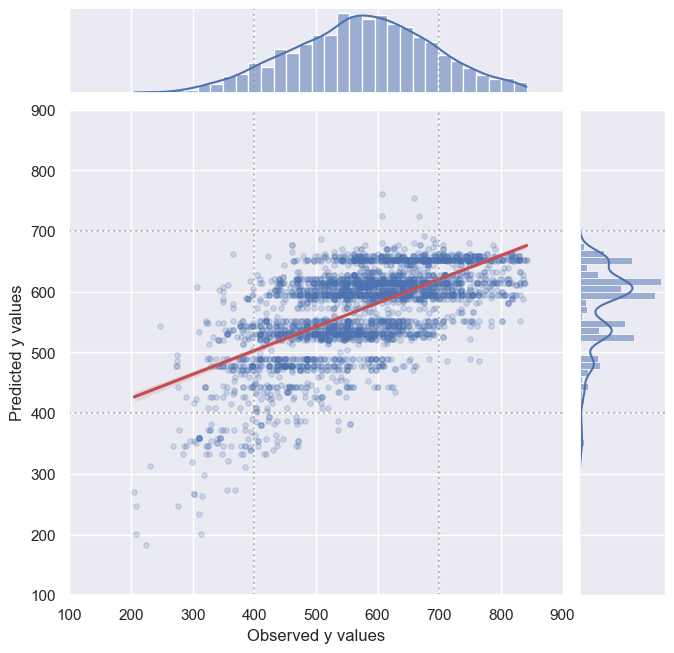

Prediction R squared: 0.3918 p-value: 0.0000
y = 0.3918x +346.4 


RESIDUALS PLOT


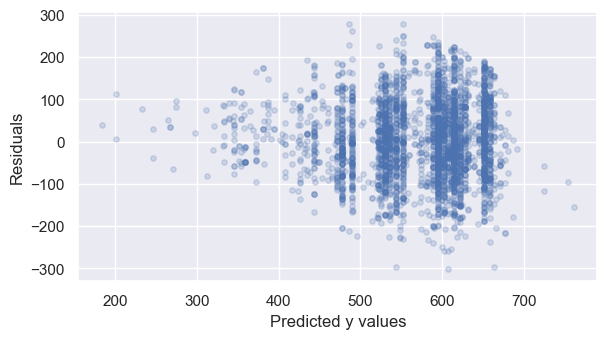

Breusch-Pegan Test for Heteroskedasticity:
If the test statistic has a p-value below 0.05, the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
Lagrange multiplier statistic: 99.5479, p-value: 0.0000

Homoskedasticity is rejected.



RESIDUALS NORMALITY
NormaltestResult(statistic=4.927907128788771, pvalue=0.08509784521089761)
KstestResult(statistic=0.4986875036789835, pvalue=0.0, statistic_location=3.0085480784313177, statistic_sign=-1)
Residuals Histogram


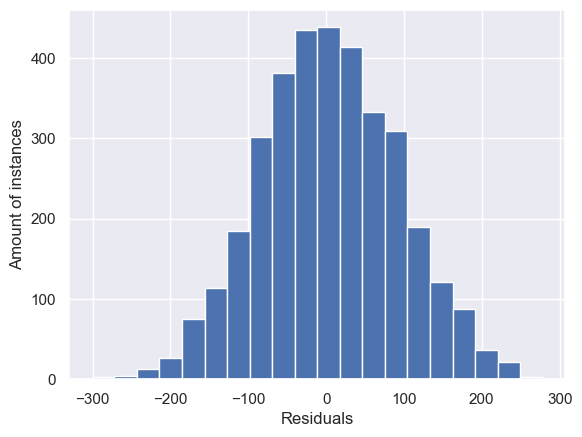

In [33]:
# Predictions and summary
y_pred = {}
OLS_model = {}

X_train_backup = X_train.copy()
X_test_backup = X_test.copy()
y_train_backup = y_train.copy()
y_test_backup = y_test.copy()
    
for cov_type in ['nonrobust', 'HC0', 'HC1', 'HC2', 'HC3']:
    for exp in aijobs['experience_level'].unique():
        print(cov_type, '\n')
        print(exp, '\n')
        OLS_model[exp] = model_creation(X_train[exp], X_test[exp], y_train[exp], y_test[exp], cov_type)
        y_pred[exp] = OLS_model[exp].predict(X_test[exp])
        display(OLS_model[exp].summary())
        print('\n___________________________________________________________\n')
    pred_y = pd.concat([y_pred['MI'], y_pred['SE'], y_pred['EN'], y_pred['EX']])
    test_y = pd.concat([y_test['MI'], y_test['SE'], y_test['EN'], y_test['EX']])
    test_X = pd.concat([X_test['MI'], X_test['SE'], X_test['EN'], X_test['EX']])
    create_scatter(pred_y, test_y, test_X)
    X_train = X_train_backup.copy()
    X_test = X_test_backup.copy()
    y_train = y_train_backup.copy()
    y_test = y_test_backup.copy()
    if cov_type != 'HC3':
        print('_____________________________________________________________________________',
              '\n\nNEXT HC\n',
              '_____________________________________________________________________________\n\n\n\n\n',
              sep='')